In [7]:
#ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# warning を非表示にする
import warnings
warnings.simplefilter('ignore')

In [4]:
train = pd.read_pickle('Pickle/titanic_train.pkl')
test = pd.read_pickle('Pickle/titanic_test.pkl')
data = [train, test]

In [5]:
data[0].head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Title,Fare_band,Age_band
0,0,3,1,1,0,0,0,0,1
1,1,1,0,1,0,1,2,4,3
2,1,3,0,0,0,0,1,0,1
3,1,1,0,1,0,0,2,3,2
4,0,3,1,0,0,0,0,1,2


- データの分割

In [6]:
from sklearn.model_selection import train_test_split
tr_train, tr_test = train_test_split(train, test_size=0.3, random_state=1234)

In [8]:
# 訓練用の説明変数
# ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Age_band', 'Fare_band']
tr_train_X = tr_train[train.columns[1:]]

# 訓練用の目的変数
# 'Survived'
tr_train_Y = tr_train[train.columns[0]]

# 評価用の説明変数
tr_test_X = tr_test[train.columns[1:]]

# 評価用の目的変数
tr_test_Y = tr_test[train.columns[0]]

## 決定木

In [9]:
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [10]:
# 訓練用の説明変数,目的変数を与えて学習させる
model.fit(tr_train_X,tr_train_Y)

# 生成されたモデルを用いて、テスト用の説明変数に対する予測値を入手
predict= model.predict(tr_test_X)

In [11]:
from sklearn import metrics

# 精度をmax 1.0で返すmatrics.accuracy_scoreを利用
# 引数にモデルにより予測された値と、実際の目的変数を与えることで正解率を計算
print('判別率：',metrics.accuracy_score(predict, tr_test_Y))

判別率： 0.7910447761194029


## ランダムフォレスト（アンサンブル学習）

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300) # 300個の木

In [13]:
model.fit(tr_train_X,tr_train_Y)
predict= model.predict(tr_test_X)

In [14]:
from sklearn import metrics
print('判別率：',metrics.accuracy_score(predict, tr_test_Y))

判別率： 0.8022388059701493


## K-分割交差検証

In [15]:
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score

kf = KFold(n_splits=5, random_state=30, shuffle=True) # 5分割

In [16]:
x = train[train.columns[1:]]
y = train.Survived
cv_result = cross_val_score(model, x, y, cv=kf)
print(cv_result)
print(f'平均精度：{cv_result.mean()}')

[0.80446927 0.7752809  0.83707865 0.79213483 0.79213483]
平均精度：0.8002196974452327


## グリッドサーチ

In [18]:
from sklearn.model_selection import GridSearchCV

# サーチしたいハイパーパラメータ、および探る範囲の指定
# 今回は、予測子の数を100~1000まで、100刻みで探る
param = {'n_estimators': range(100, 1000, 100)}

# 分類器はランダムフォレストを指定
# cvに与えた数値分だけ、交差検証を行う
GS_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                     param_grid=param,
                     verbose=True,
                     cv=5)
GS_rf.fit(x, y)

print("ベストスコア：{}".format(GS_rf.best_score_))
print("最適なパラメータ：{}".format(GS_rf.best_estimator_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
ベストスコア：0.8103320569957944
最適なパラメータ：RandomForestClassifier(n_estimators=500, random_state=0)


In [19]:
# グリッドサーチで得られたベストなモデルを用いて分類を行う
model = GS_rf.best_estimator_

# 学習
model.fit(train[train.columns[1:]] ,train[train.columns[0]])

# テストデータに対する予測
test_prediction = model.predict(test)

In [20]:
# kaggleの課題として PassengerId 892 ~ 1310 を予測することが要求されているため
# idを生成しておく
passenger_id = np.arange(892,1310)

In [21]:
# PassengerIdと予測結果をデータフレーム化
test_result = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_prediction } )
print(test_result.head(10))

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         0
7          899         0
8          900         1
9          901         0


In [22]:
# 生成したデータフレームをcsvとして保存
test_result.to_csv('Result/titanic_forsubmisson.csv', index=False)

<AxesSubplot:ylabel='feature_importances'>

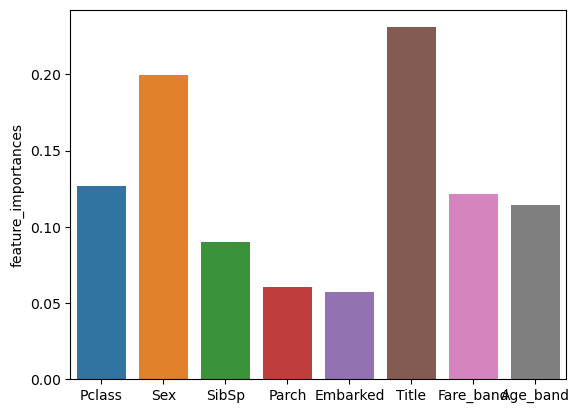

In [23]:
# 分類に用いた説明変数について、それぞれが分類に貢献した度合いをfeature_importances_で取得できる
feature_importances= pd.DataFrame({"feature_importances":model.feature_importances_})
sns.barplot(tr_train_X.columns, feature_importances["feature_importances"])